In [1]:
# Setup step - load all our libraries
# These are chosen for speed of development and understanding, not performance!

import json
import pickle
import csv
from collections import namedtuple, defaultdict

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics

import matplotlib.pyplot as plt

# Try to import things for Notebook display/rendering
try:
    from IPython.display import display, HTML
    notebook = True
except ImportError:
    notebook = False

In [2]:
# Read in the JSON files of the talk abstracts
# Convert these into Panda DataFrames
# If we didn't need to tweak things, could be done with pandas.read_json

keys = ("year","title","level","track","speaker","url","abstract")
years = (2021,2020,2019,2018,2017,2016,2015)

data = {}
for k in keys:
    data[k] = []
for year in years:
    filename = "data/%d/sessions.json" % year
    print("Loading %s" % filename)
    
    with open(filename) as f:
       d = json.load(f)
       for talk in d:
            talk["year"] = year
            for k in keys:
                data[k].append( talk[k] )
                
print("Loaded %d talks from %d years" % (len(data["year"]),len(years)))
talks = pd.DataFrame.from_dict(data)

# Build an "learn" field, by combining the bits we want to learn on
talks["learn"] = talks["title"] + " " + talks["track"] + " " + talks["abstract"]

# ----------------------------------------------------------------------------

# At this point, you might want to explore the data a bit
talks.head(5)

Loading data/2021/sessions.json
Loading data/2020/sessions.json
Loading data/2019/sessions.json
Loading data/2018/sessions.json
Loading data/2017/sessions.json
Loading data/2016/sessions.json
Loading data/2015/sessions.json
Loaded 421 talks from 7 years


,year,title,level,track,speaker,url,abstract,learn
0,2021,5 min to discover an open source enterprise se...,Beginner,Search,Cédric Ulmer,https://2021.berlinbuzzwords.de/session/5-min-...,So your boss wants you to setup a multisources...,5 min to discover an open source enterprise se...
1,2021,The Acceleration of Cloud Engineering and AI -...,Beginner,Scale,Grace Francisco,https://2021.berlinbuzzwords.de/session/accele...,Covid-19 put fuel to rising trends and acceler...,The Acceleration of Cloud Engineering and AI -...
2,2021,Applied MLOps to Maintain Model Freshness on K...,Intermediate,Scale,Jeff Zemerick,https://2021.berlinbuzzwords.de/session/applie...,As machine learning becomes more pervasive acr...,Applied MLOps to Maintain Model Freshness on K...
3,2021,"""Are You Sure?"": blending product comparisons ...",Advanced,Search,Patrick John Chia,https://2021.berlinbuzzwords.de/session/are-yo...,How do shoppers pick a single product out of t...,"""Are You Sure?"": blending product comparisons ..."
4,2021,Ask Me Anything: Vector Search!,All,Search,Dmitry Kan,https://2021.berlinbuzzwords.de/session/ask-me...,Get to know about vector search and ask Dmitry...,Ask Me Anything: Vector Search! Search Get to ...


In [3]:
# Build two different TF-IDF matricies
# One which is word based, one which is character based
# Do n-grams for both
#  - for words this permits pseudo-phrase-queries
#  - for characters this permits pseudo-stemming and typo fixing
# Build these over just the "learn" combined column
# Then generate an inter-document similarity
TFIDF = namedtuple('TFIDF', 'tfidf matrix similarities settings')

tf_settings_word = dict( analyzer="word",    ngram_range=(1,2) )
tf_settings_char = dict( analyzer="char_wb", ngram_range=(3,4) )
tf_settings_base = dict( sublinear_tf=True, min_df=0, stop_words='english' )

def build_tfidf(tf_settings, text_to_process):
    print("Building TFI for: %s" % tf_settings)
    tfs = dict(tf_settings)
    tfs.update(tf_settings_base)

    # Build the TF-IDF over all the talks
    # Use title + category + abstract for our text
    tfidf = TfidfVectorizer(**tfs)
    tfidf_matrix = tfidf.fit_transform(text_to_process)
    tfidf_matrix.shape
    print(" - TF-IDF has %d entries" % tfidf_matrix.shape[1])
    
    # Build the similarities of each talk against every other talk
    # We'll use this for scoring
    tfidf_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Return this bundle ready for re-use
    return TFIDF(tfidf, tfidf_matrix, tfidf_similarities, tfs)

tfidf_word = build_tfidf(tf_settings_word, talks["learn"])
tfidf_char = build_tfidf(tf_settings_char, talks["learn"])

# Let's see what some of our terms are
print(tfidf_word.tfidf.get_feature_names()[:10])
print(tfidf_char.tfidf.get_feature_names()[:10])

Building TFI for: {'analyzer': 'word', 'ngram_range': (1, 2)}
 - TF-IDF has 39337 entries
Building TFI for: {'analyzer': 'char_wb', 'ngram_range': (3, 4)}
 - TF-IDF has 24164 entries
['000', '000 000', '000 client', '000 merchants', '000 predictions', '000 requests', '06', '06 11', '0s', '0s actually']
[' ! ', ' "a', ' "a ', ' "ai', ' "ar', ' "b', ' "ba', ' "be', ' "bi', ' "bl']


In [4]:
# Now, build a ML model for each
models = []
for tfidf in (tfidf_word, tfidf_char):
    print("Building model for: %s" % tfidf.settings)
    
    # Build a model, using Multinomial Naive Bayse
    # Model the text of the talk, to predict the talk's index
    classifier = MultinomialNB()
    model = make_pipeline(tfidf.tfidf, classifier)
    learn_text = talks["learn"]
    model.fit( list(learn_text), list(learn_text.index) )

    # Save for later predictions
    models.append({
        "model": model,
        "tfidf": tfidf,
        "classifier": classifier
    })
    print(" - model built!")

# ----------------------------------------------------------------------------

# Code to recommend talks based on a query
# Will return the indexes of the talks, ranked
def recommend(query, model_dict, max_hits=10):
    # Ask the model to compare our query against every talk,
    #  then pick the talk it thinks is the most similar
    pred_idx = model_dict["model"].predict([query])

    # The prediction should be the index of that talk
    print("Best match - talk %d" % pred_idx)
    print(talks.iloc[pred_idx,:]["title"])
    
    # Get the pairwise similarity scores of all other talks with that one
    # Filter for ones high enough, and sort so highest scores come first
    similarities = model_dict["tfidf"].similarities[pred_idx]
    sim_scores = list( [idx,s] for idx,s in enumerate(similarities[0]) if s > 0.01 )
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indexes and scores of the x most similar talks
    sim_scores = sim_scores[0:max_hits]
    
    # Grab those talks
    indexes = [i[0] for i in sim_scores]
    return talks.iloc[indexes]

# ----------------------------------------------------------------------------

# Pretty-print our DataFrames
def render(df):
    if notebook:
        display(HTML(df.to_html()))
    else:
        print(df)

# Let's try it!
queries = ("apache tika", "ngram", "nlp", "storm spark", "bm25")
for q in queries:
    print("")
    print(q)
    print("")
    render( recommend(q, models[0],5) )
    print("")
    render( recommend(q, models[1],5) )
    print("")

Building model for: {'analyzer': 'word', 'ngram_range': (1, 2), 'sublinear_tf': True, 'min_df': 0, 'stop_words': 'english'}
 - model built!
Building model for: {'analyzer': 'char_wb', 'ngram_range': (3, 4), 'sublinear_tf': True, 'min_df': 0, 'stop_words': 'english'}
 - model built!

apache tika

Best match - talk 75
75    What's new in Apache Tika 2.0 -- we mean it th...
Name: title, dtype: object

Best match - talk 75
75    What's new in Apache Tika 2.0 -- we mean it th...
Name: title, dtype: object


ngram

Best match - talk 0
0    5 min to discover an open source enterprise se...
Name: title, dtype: object

Best match - talk 108
108    Opening Session
Name: title, dtype: object


nlp



,year,title,level,track,speaker,url,abstract,learn
75,2021,What's new in Apache Tika 2.0 -- we mean it this time!,Intermediate,Search,Tim Allison,https://2021.berlinbuzzwords.de/session/whats-new-apache-tika-20-we-mean-it-time,"Apache Tika is used in big data document processing pipelines to extract text and metadata from numerous file formats. Text extraction is a critical component for search systems. While work on 2.0 has been ongoing for years, the Tika team released 2.0.0-ALPHA in January and will release 2.0.0 before Buzzwords 2021. In addition to dramatically increased modularization, there are new components to improve scaling, integration and robustness. This talk will offer an overview of the changes in Tika 2.0 with a deep dive on the new tika-pipes module that enables synchronous and asynchronous fetching from numerous data sources (jdbc, fileshare, S3), parsing and then emitting to other endpoints (fileshare, S3, Solr, Elasticsearch, etc).","What's new in Apache Tika 2.0 -- we mean it this time! Search Apache Tika is used in big data document processing pipelines to extract text and metadata from numerous file formats. Text extraction is a critical component for search systems. While work on 2.0 has been ongoing for years, the Tika team released 2.0.0-ALPHA in January and will release 2.0.0 before Buzzwords 2021. In addition to dramatically increased modularization, there are new components to improve scaling, integration and robustness. This talk will offer an overview of the changes in Tika 2.0 with a deep dive on the new tika-pipes module that enables synchronous and asynchronous fetching from numerous data sources (jdbc, fileshare, S3), parsing and then emitting to other endpoints (fileshare, S3, Solr, Elasticsearch, etc)."
57,2021,Opening and Welcoming,Beginner,Scale,Nina Müller,https://2021.berlinbuzzwords.de/session/opening-and-welcoming,Berlin Buzzwords 2021 kicks off!,Opening and Welcoming Scale Berlin Buzzwords 2021 kicks off!
382,2015,What's with the 1s and 0s? Making sense of binary data at scale,Beginner,Search,Nick Burch,https://2015.berlinbuzzwords.de/session/whats-1s-and-0s-making-sense-binary-data-scale-0.html,"If you have one or two files, you can take the time to manually work out what they are, what they contain, and how to get the useful bits out (probably....). However, this approach really doesn't scale, mechanical turks or no! Luckily, there are open source projects and libraries out there which can help, and which can scale!\nIn this talk, we'll first look at how we can work out what a given blob of 1s and 0s actually is, be it textual or binary. We'll then see how to extract common metadata from it, along with text, embedded resources, images, and maybe even the kitchen sink! We'll see how to use things like Apache Tika to do this, along with some other libraries to complement it. Once that part's all sorted, we'll look at how to roll this all out for a large-scale Search or Big Data setup, helping you turn those 1s and 0s into useful content at scale!\n","What's with the 1s and 0s? Making sense of binary data at scale Search If you have one or two files, you can take the time to manually work out what they are, what they contain, and how to get the useful bits out (probably....). However, this approach really doesn't scale, mechanical turks or no! Luckily, there are open source projects and libraries out there which can help, and which can scale!\nIn this talk, we'll first look at how we can work out what a given blob of 1s and 0s actually is, be it textual or binary. We'll then see how to extract common metadata from it, along with text, embedded resources, images, and maybe even the kitchen sink! We'll see how to use things like Apache Tika to do this, along with some other libraries to complement it. Once that part's all sorted, we'll look at how to roll this all out for a large-scale Search or Big Data setup, helping you turn those 1s and 0s into useful content at scale!\n"
203,2018,

,year,title,level,track,speaker,url,abstract,learn
75,2021,What's new in Apache Tika 2.0 -- we mean it this time!,Intermediate,Search,Tim Allison,https://2021.berlinbuzzwords.de/session/whats-new-apache-tika-20-we-mean-it-time,"Apache Tika is used in big data document processing pipelines to extract text and metadata from numerous file formats. Text extraction is a critical component for search systems. While work on 2.0 has been ongoing for years, the Tika team released 2.0.0-ALPHA in January and will release 2.0.0 before Buzzwords 2021. In addition to dramatically increased modularization, there are new components to improve scaling, integration and robustness. This talk will offer an overview of the changes in Tika 2.0 with a deep dive on the new tika-pipes module that enables synchronous and asynchronous fetching from numerous data sources (jdbc, fileshare, S3), parsing and then emitting to other endpoints (fileshare, S3, Solr, Elasticsearch, etc).","What's new in Apache Tika 2.0 -- we mean it this time! Search Apache Tika is used in big data document processing pipelines to extract text and metadata from numerous file formats. Text extraction is a critical component for search systems. While work on 2.0 has been ongoing for years, the Tika team released 2.0.0-ALPHA in January and will release 2.0.0 before Buzzwords 2021. In addition to dramatically increased modularization, there are new components to improve scaling, integration and robustness. This talk will offer an overview of the changes in Tika 2.0 with a deep dive on the new tika-pipes module that enables synchronous and asynchronous fetching from numerous data sources (jdbc, fileshare, S3), parsing and then emitting to other endpoints (fileshare, S3, Solr, Elasticsearch, etc)."
351,2016,Event Sourcing in Yammer,Intermediate,Scale,Michal RutkowskiDmitry StratiychukPhilipp Fehre,https://2016.berlinbuzzwords.de/session/event-sourcing-yammer.html,"Event Sourcing brings the promise of highly-scalable and loosely-coupled systems that are performant, reliable, and maintainable. It looked like a perfect solution for Yammer's reliability and performance challenges, but nothing comes for free!\nOnly slightly over a year ago, Yammer's entire system was either based on synchronous calls or Ruby workers and RabbitMQ. For a while, we have been moving performance-critical components out of the Ruby on Rails monolith toward Dropwizard-based services. This has served us well, but with increased reliability requirements, the pressure to simplify and decouple our system's architecture also increased.\nOver the course of the last year, we first created a prototype implementation of Event Sourcing and, after validating the idea, have been moving it to a managed Azure Event Hubs based solution. \nWe are going to cover not only how to migrate to a new technology, but also look at how to change organizational thinking from a synchronous world to one of event streams. We will tell the war stories of our migration from a self-hosted Kafka cluster to a solution based in the cloud. \n","Event Sourcing in Yammer Scale Event Sourcing brings the promise of highly-scalable and loosely-coupled systems that are performant, reliable, and maintainable. It looked like a perfect solution for Yammer's reliability and performance challenges, but nothing comes for free!\nOnly slightly over a year ago, Yammer's entire system was either based on synchronous calls or Ruby workers and RabbitMQ. For a while, we have been moving performance-critical components out of the Ruby on Rails monolith toward Dropwizard-based services. This has served us well, but with increased reliability requirements, the pressure to simplify and decouple our system's architecture also increased.\nOver the course of the last year, we first created a prototype implementation of Event Sourcing and, after validating the idea, have been moving it to a managed Azure Event Hubs based solution. \nWe are going to cover not only how to migra

,year,title,level,track,speaker,url,abstract,learn
0,2021,5 min to discover an open source enterprise search solution,Beginner,Search,Cédric Ulmer,https://2021.berlinbuzzwords.de/session/5-min-discover-open-source-enterprise-search-solution,"So your boss wants you to setup a multisources/multiformats search engine, and he thinks it requires 5 min to do so ? Well, the best we can do, is to show you what Datafari - an open source enterprise search solution - can (and cannot do) in 5 min, and then you will have more food to build a realistic scenario for your boss.","5 min to discover an open source enterprise search solution Search So your boss wants you to setup a multisources/multiformats search engine, and he thinks it requires 5 min to do so ? Well, the best we can do, is to show you what Datafari - an open source enterprise search solution - can (and cannot do) in 5 min, and then you will have more food to build a realistic scenario for your boss."
33,2021,Enterprise Search 101 with Datafari Open Source,Beginner,Search,Julien Massiera,https://2021.berlinbuzzwords.de/session/enterprise-search-101-datafari-open-source-0,"Datafari is among the few available open source Enterprise Search solutions.\nIt can be useful to index your hard drives, your organisation fileshares, but also many other types of sources and formats. Several connectors are available off the shelf (Sharepoint, SMB, DB, web, Alfresco...).\nSo what is the difference with Solr or openDistro ? It is an additional layer: Datafari is not just the search engine per se, it also embeds the crawling framework, a search UI, and an admin UI.\nIn this initiation workshop, we will first introduce Datafari and its architecture, and we will then directly dive into a quick install and indexing phase: how to install Datafari Community Edition, create first crawlers and configuration, and how to customise the UI.\nWith that, you can benefit from Apache Tika, Apache ManifoldCF, Apache Solr, and openDistro without the hassle of configuring and interconnecting all of them.","Enterprise Search 101 with Datafari Open Source Search Datafari is among the few available open source Enterprise Search solutions.\nIt can be useful to index your hard drives, your organisation fileshares, but also many other types of sources and formats. Several connectors are available off the shelf (Sharepoint, SMB, DB, web, Alfresco...).\nSo what is the difference with Solr or openDistro ? It is an additional layer: Datafari is not just the search engine per se, it also embeds the crawling framework, a search UI, and an admin UI.\nIn this initiation workshop, we will first introduce Datafari and its architecture, and we will then directly dive into a quick install and indexing phase: how to install Datafari Community Edition, create first crawlers and configuration, and how to customise the UI.\nWith that, you can benefit from Apache Tika, Apache ManifoldCF, Apache Solr, and openDistro without the hassle of configuring and interconnecting all of them."
323,2016,Community & Commercialization: How to Build an Open Source Company in 2016,Beginner,Search,Will Hayes,https://2016.berlinbuzzwords.de/session/community-commercialization-how-build-open-source-company-2016.html,"Many companies tout themselves as “open source,” offering support for popular tools and technologies. But professional services alone don’t typically produce the kind of revenue required for long term business success. So what does it take to build a profitable and healthy open source company? In this session, Will Hayes, CEO of Lucidworks — the company built on and around Apache Lucene and Solr — will share how business success need not come at the expense of the open source community’s integrity. Using Lucidworks as a case study Hayes will explain the power of specificity in driving both revenue and committer happiness, exploring why open source companies should avoid commercializing product features with broad, cross-industry appeal, suc

,year,title,level,track,speaker,url,abstract,learn
108,2020,Opening Session,All,Community,Nina Müller,https://2020.berlinbuzzwords.de/session/opening-session,"Welcome to the first Berlin Buzzwords online conference. Learn more about our program structure, networking possibilities and more.","Opening Session Community Welcome to the first Berlin Buzzwords online conference. Learn more about our program structure, networking possibilities and more."
57,2021,Opening and Welcoming,Beginner,Scale,Nina Müller,https://2021.berlinbuzzwords.de/session/opening-and-welcoming,Berlin Buzzwords 2021 kicks off!,Opening and Welcoming Scale Berlin Buzzwords 2021 kicks off!
86,2020,Closing session,Beginner,Community,Nina Müller,https://2020.berlinbuzzwords.de/session/closing-session-0,"Join us for some parting words from the organizers of Berlin Buzzwords, Haystack and MICES.","Closing session Community Join us for some parting words from the organizers of Berlin Buzzwords, Haystack and MICES."
97,2020,Joint opening session MICES and Haystack,All,Community,René Kriegler,https://2020.berlinbuzzwords.de/session/joint-opening-session-mices-and-haystack,We welcome you to joint virtual MICES and Haystack conferences 2020.,Joint opening session MICES and Haystack Community We welcome you to joint virtual MICES and Haystack conferences 2020.
80,2020,Barcamp,All,Community,Varun Thacker,https://2020.berlinbuzzwords.de/session/barcamp,"Each year at Berlin Buzzwords we like to get together on the Sunday before the main conference schedule begins for a Barcamp and this year’s online conference is no exception!Barcamps are informal sessions, a kind of ""un-conference"", with a schedule decided on the day. It is all driven by the interests and expertise of those who attend so each one is different, but ours are always great!\nAlthough the barcamp doesn't have a strict schedule, it won't be completely devoid of structure! #bbuzz barcamps are dynamic events, focused on the overall Berlin Buzzwords topics, tackling the same challenges but in a different format\nJoin the discussion at berlinbuzzwords.slack.com","Barcamp Community Each year at Berlin Buzzwords we like to get together on the Sunday before the main conference schedule begins for a Barcamp and this year’s online conference is no exception!Barcamps are informal sessions, a kind of ""un-conference"", with a schedule decided on the day. It is all driven by the interests and expertise of those who attend so each one is different, but ours are always great!\nAlthough the barcamp doesn't have a strict schedule, it won't be completely devoid of structure! #bbuzz barcamps are dynamic events, focused on the overall Berlin Buzzwords topics, tackling the same challenges but in a different format\nJoin the discussion at berlinbuzzwords.slack.com"


Best match - talk 347
347    Gain speed and space with NLP in Solr
Name: title, dtype: object

Best match - talk 347
347    Gain speed and space with NLP in Solr
Name: title, dtype: object


storm spark

Best match - talk 420
420    Low latency scalable web crawling on Apache Storm
Name: title, dtype: object



,year,title,level,track,speaker,url,abstract,learn
347,2016,Gain speed and space with NLP in Solr,Intermediate,Search,Tobias Kässmann,https://2016.berlinbuzzwords.de/session/gain-speed-and-space-nlp-solr.html,With 100M+ products in a single Solr index it is hard work to keep response times as low as possible. A key factor is decreasing the index size and the number of terms indexed. We try to store the significant terms only. For long product descriptions this is challenging. Applying NLP at index time is a costly operation. In this talk I’ll present a smart algorithm that run fast enough to be applied at index time.\n,Gain speed and space with NLP in Solr Search With 100M+ products in a single Solr index it is hard work to keep response times as low as possible. A key factor is decreasing the index size and the number of terms indexed. We try to store the significant terms only. For long product descriptions this is challenging. Applying NLP at index time is a costly operation. In this talk I’ll present a smart algorithm that run fast enough to be applied at index time.\n
401,2015,Beyond significant terms,Intermediate,Search,André Lynum,https://2015.berlinbuzzwords.de/session/beyond-significant-terms.html,"In Comperio we work on projects that aim to learn from the documents and social activity published on the web. The challenge is to summarize recent activity, drawing together current events with past activity and finding new sources to learn from. We base our on Elasticsearch and its significant terms technology. In this presentation we show how we expand on the base functionality provided in Elasticsearch to focus on areas such as immediate trends, entity identification and topic building using additional techniques from Information Retrieval (IR) and Natural Language Processing (NLP).\n","Beyond significant terms Search In Comperio we work on projects that aim to learn from the documents and social activity published on the web. The challenge is to summarize recent activity, drawing together current events with past activity and finding new sources to learn from. We base our on Elasticsearch and its significant terms technology. In this presentation we show how we expand on the base functionality provided in Elasticsearch to focus on areas such as immediate trends, entity identification and topic building using additional techniques from Information Retrieval (IR) and Natural Language Processing (NLP).\n"
260,2017,Update on the t-digest: Finding Faults in Real Data,Intermediate,Search,Ted Dunning,https://2017.berlinbuzzwords.de/17/session/update-t-digest-finding-faults-real-data.html,"Is your system working? Really? Average response times and throughputs don’t tell the whole story. To really understand what is happening, you probably need measurements like the 99.9%-ile response time. A growing number of systems are using the t-digest to do this. I will explain the algorithm with practical examples, talk about how it is much simpler and faster than before, talk about integration in systems like Elastic, Solar and streamlib, tell some real-world deployment stories and show some pretty pictures.","Update on the t-digest: Finding Faults in Real Data Search Is your system working? Really? Average response times and throughputs don’t tell the whole story. To really understand what is happening, you probably need measurements like the 99.9%-ile response time. A growing number of systems are using the t-digest to do this. I will explain the algorithm with practical examples, talk about how it is much simpler and faster than before, talk about integration in systems like Elastic, Solar and streamlib, tell some real-world deployment stories and show some pretty pictures."
171,2019,E-Commerce search at scale on Apache Lucene (tm),Intermediate,Search,Michael SokolovMike McCandless,https://2019.berlinbuzzwords.de/19/session/e-commerce-search-scale-apache-lucene-tm.html,"After many years running its own in-house C++ search engine, Ama

,year,title,level,track,speaker,url,abstract,learn
347,2016,Gain speed and space with NLP in Solr,Intermediate,Search,Tobias Kässmann,https://2016.berlinbuzzwords.de/session/gain-speed-and-space-nlp-solr.html,With 100M+ products in a single Solr index it is hard work to keep response times as low as possible. A key factor is decreasing the index size and the number of terms indexed. We try to store the significant terms only. For long product descriptions this is challenging. Applying NLP at index time is a costly operation. In this talk I’ll present a smart algorithm that run fast enough to be applied at index time.\n,Gain speed and space with NLP in Solr Search With 100M+ products in a single Solr index it is hard work to keep response times as low as possible. A key factor is decreasing the index size and the number of terms indexed. We try to store the significant terms only. For long product descriptions this is challenging. Applying NLP at index time is a costly operation. In this talk I’ll present a smart algorithm that run fast enough to be applied at index time.\n
202,2018,Learned Indexes: a New Idea for Efficient Data Access,Intermediate,Store,Robert Rodger,https://2018.berlinbuzzwords.de/18/session/learned-indexes-new-idea-efficient-data-access.html,"Indexes are what make efficient access for our data storage systems possible. Though traditionally implemented with highly-optimized tree-based data structures, this past December a group from Google proposed a novel idea: replace certain types of index structures with trained machine learning algorithms. After all, an index is nothing other than a model that maps a key to the position of a record; in this light, exchanging, say, your B-tree search with a deep neural network prediction seems at least possible, if not practical. Surprisingly, doing so can often lead to significant performance improvements, in terms of both time and memory consumption.\nIn this talk we discuss how learned indexes accomplish this. We focus on neural networks, and in particular how recent trends in processor architecture design make them computationally competitive against tree search. We then have a look at how machine learning algorithms can be applied to the task of range indexation, how they can deliver error bound guarantees, and how their accuracy can be honed by layering them recursively. We finish with a review of the Google group's results on three realistic datasets and a brief mention of how machine learning can be applied to other indexation tasks.\n","Learned Indexes: a New Idea for Efficient Data Access Store Indexes are what make efficient access for our data storage systems possible. Though traditionally implemented with highly-optimized tree-based data structures, this past December a group from Google proposed a novel idea: replace certain types of index structures with trained machine learning algorithms. After all, an index is nothing other than a model that maps a key to the position of a record; in this light, exchanging, say, your B-tree search with a deep neural network prediction seems at least possible, if not practical. Surprisingly, doing so can often lead to significant performance improvements, in terms of both time and memory consumption.\nIn this talk we discuss how learned indexes accomplish this. We focus on neural networks, and in particular how recent trends in processor architecture design make them computationally competitive against tree search. We then have a look at how machine learning algorithms can be applied to the task of range indexation, how they can deliver error bound guarantees, and how their accuracy can be honed by layering them recursively. We finish with a review of the Google group's results on three realistic datasets and a brief mention of how machine learning can be applied to other indexation tasks.\n"
392,2015,Designing Concurrent Distributed Sequence Numbers for Elasticsearch,Intermediate,Scale,Boaz Leskes,https://2015.berlinbuzz

,year,title,level,track,speaker,url,abstract,learn
420,2015,Low latency scalable web crawling on Apache Storm,Beginner,Search,Julien Nioche,https://2015.berlinbuzzwords.de/session/low-latency-scalable-web-crawling-apache-storm.html,"In this talk I will introduce Storm-Crawler https://github.com/DigitalPebble/storm-crawler, a collection of resources for building low-latency, large scale web crawlers on Apache Storm. We will compare with similar projects like Apache Nutch and present several use cases where the storm-crawler is being used. In particular we will see how the Storm-crawler can be used with ElasticSearch and Kibana for crawling and indexing web pages.\n","Low latency scalable web crawling on Apache Storm Search In this talk I will introduce Storm-Crawler https://github.com/DigitalPebble/storm-crawler, a collection of resources for building low-latency, large scale web crawlers on Apache Storm. We will compare with similar projects like Apache Nutch and present several use cases where the storm-crawler is being used. In particular we will see how the Storm-crawler can be used with ElasticSearch and Kibana for crawling and indexing web pages.\n"
346,2016,"Real Time Marketing with Kafka, Storm, Cassandra and a pinch of Spark",Beginner,Scale,Volker Janz,https://2016.berlinbuzzwords.de/session/real-time-marketing-kafka-storm-cassandra-and-pinch-spark.html,"The combination of Apache Kafka as a event bus, Apache Storm for real- or neartime processing, Apache Cassandra as an operational storage layer as well as Apache Spark to perform analytical queries against this storage turned out to be a extremely well performing system.\nWith increasing marketing costs per registration, it is even more important to keep players within the game as well as provide them with attractive offers aiming to increase the customer lifetime value and also create a better game experience.\nTo that end, we introduced interstitials that offer premium features or discounts for the player at InnoGames. Even though this is already a useful instrument, we aimed to customize those interstitials according to the behavior of the player. Therefore, we created a system that works with generic messages that contain data about user interactions, in real- or neartime -- later referred to as events. The system builds up a player profile that contains all game-relevant information about the players in a central location.\nThe system is also able to react to events, fetch information about the corresponding player from the profile in a matter of milliseconds and send out an interstitial based on this information.\nThe system consists of an Apache Kafka component used as an event bus, an Apache Storm topology to update the profile and trigger marketing actions based on events as well as an Apache Cassandra cluster which serves as a storage layer for the profile. In addition, we set up a Apache Spark cluster along Cassandra to run analytical queries against the data in Cassandra based on this article from DataStax (https://academy.datastax.com/demos/getting-started-apache-spark-and-cassandra). This combination is quite efficient but additionally we added a Spark REST JobServer (https://github.com/spark-jobserver/spark-jobserver) and extended it so that we can read the player profile from Cassandra, cache it within the Spark context and reuse this context for several jobs. This increases the performance for analytical queries significantly.\nThe whole stack combines the possibility of fast event-based operations along with powerful analytical queries using Spark DataFrames. This concept can therefore not only be applied to a marketing system like the one we built, but also to a variety of different use cases. Another key technology used within the system is the Nashorn JavaScript engine included with Java 8. It is used within Storm to work with the player profile and the incoming events. In this way we are able to define new marketing action at runtime and have a ve

Best match - talk 312
312    Apache Spark? If only it worked.
Name: title, dtype: object


bm25

Best match - talk 342
342    BM25 demystified
Name: title, dtype: object

Best match - talk 342
342    BM25 demystified
Name: title, dtype: object



,year,title,level,track,speaker,url,abstract,learn
312,2017,Apache Spark? If only it worked.,Intermediate,Scale,Marcin Szymaniuk,https://2017.berlinbuzzwords.de/17/session/apache-spark-if-only-it-worked.html,"Do you have plans to start working with Apache Spark? Are you already working with Spark but you haven’t gotten the expected performance and stability and you are not sure where to look for a fix?\nSpark has a very nice API and it promises high performance for crunching large datasets. It’s really easy to write an app in Spark, unfortunately, it’s also easy to write one which doesn’t perform the way you would expect or just fails for no obvious reason.\nThis talk will consist of multiple common problems you might face when running Spark at full scale and, of course, solutions for solving them. Each of the problems I will cover will come with well-described background and examples so that it will be understood by people with no Spark experience. However, people who are working with Spark are the main audience. The ultimate objective is to give the audience a practical framework for optimizing the most common problems with Spark applications.\nClasses of problems in the presentation:\nDealing with skewed data\nSpark on YARN and its memory model\nCaching\nSizing executors\nLocality\n","Apache Spark? If only it worked. Scale Do you have plans to start working with Apache Spark? Are you already working with Spark but you haven’t gotten the expected performance and stability and you are not sure where to look for a fix?\nSpark has a very nice API and it promises high performance for crunching large datasets. It’s really easy to write an app in Spark, unfortunately, it’s also easy to write one which doesn’t perform the way you would expect or just fails for no obvious reason.\nThis talk will consist of multiple common problems you might face when running Spark at full scale and, of course, solutions for solving them. Each of the problems I will cover will come with well-described background and examples so that it will be understood by people with no Spark experience. However, people who are working with Spark are the main audience. The ultimate objective is to give the audience a practical framework for optimizing the most common problems with Spark applications.\nClasses of problems in the presentation:\nDealing with skewed data\nSpark on YARN and its memory model\nCaching\nSizing executors\nLocality\n"
225,2018,DataFrames in Spark - the analysts perspective.,Beginner,Scale,Marcin Szymaniuk,https://2018.berlinbuzzwords.de/18/session/dataframes-spark-analysts-perspective.html,"Are you a data analyst who works with Spark and often gets confused by failures you don’t understand? Have you seen a bunch of presentations or blog posts about Spark performance but you are still not certain how to apply the hints you have been given in practice?\nSpark is commonly used by people who are not experts in programming but they know SQL and sometimes basic Python. They treat Spark as a tool for getting business value from the the data. And that is how it should be! Although it’s common that queries they run do not work for any obvious reason. This talk is designed for such Spark users and will be focused on common problems with Spark (especially DataFrames and SQL) which can be solved by anyone familiar with SQL. You don’t need to read bytecode to understand the techniques presented and apply them in practice!\nThis talk will be a case study of multiple DataFrame queries in Spark which initially do not work. I will not only explain how to fix them, but we will go through the solution step-by-step so you will learn what to pay attention to and how to apply similar techniques to your codebase!\n","DataFrames in Spark - the analysts perspective. Scale Are you a data analyst who works with Spark and often gets confused by failures you don’t understand? Have you seen a bunch of presentations or blog posts about Spark performance but you are still 

,year,title,level,track,speaker,url,abstract,learn
342,2016,BM25 demystified,Intermediate,Search,Britta Weber,https://2016.berlinbuzzwords.de/session/bm25-demystified.html,"Lucene will change the default scoring from TF/IDF to BM25 in the next major release. So unless you really enjoy surprises you better learn about it now! TF/IDF was easy enough to understand intuitively but how is it with BM25? What do all these parameters do? And what do people mean when they say it is ""probabilistic""? In this talk I will tell the story of how we came from the Probability Ranking Principle to BM25 with a minimum of math and a maximum of explaining. I will also show how BM25 differs from TF/IDF, what it means in practice and give and intuition on what the parameters of this method actually do. You will leave this talk feeling good about Lucene changing the default. And of course you will learn many fancy buzzwords to show off with during the breaks.\n","BM25 demystified Search Lucene will change the default scoring from TF/IDF to BM25 in the next major release. So unless you really enjoy surprises you better learn about it now! TF/IDF was easy enough to understand intuitively but how is it with BM25? What do all these parameters do? And what do people mean when they say it is ""probabilistic""? In this talk I will tell the story of how we came from the Probability Ranking Principle to BM25 with a minimum of math and a maximum of explaining. I will also show how BM25 differs from TF/IDF, what it means in practice and give and intuition on what the parameters of this method actually do. You will leave this talk feeling good about Lucene changing the default. And of course you will learn many fancy buzzwords to show off with during the breaks.\n"
306,2017,BM25 is so Yesterday: Modern Techniques for Better Search Relevance,Intermediate,Search,Grant Ingersoll,https://2017.berlinbuzzwords.de/17/session/bm25-so-yesterday-modern-techniques-better-search-relevance.html,"Modern relevance in search engines has come a long way since the early days of information retrieval, when the likes of TF-IDF and BM25 scoring models first came on the scene. And while those core models are still good for a first pass retrieval, more and more search engines are employing machine learning, natural language processing and sophisticated re-ranking techniques to fine tune relevance. This talk will provide a review of current best practices in relevance tuning, including what to measure and how to measure it. We’ll then give details on how to use techniques like learning to rank and query intent classification to improve results, with examples in Apache Solr. We’ll finish with a sneak peak into using deep learning and word2vec in a search context.\n","BM25 is so Yesterday: Modern Techniques for Better Search Relevance Search Modern relevance in search engines has come a long way since the early days of information retrieval, when the likes of TF-IDF and BM25 scoring models first came on the scene. And while those core models are still good for a first pass retrieval, more and more search engines are employing machine learning, natural language processing and sophisticated re-ranking techniques to fine tune relevance. This talk will provide a review of current best practices in relevance tuning, including what to measure and how to measure it. We’ll then give details on how to use techniques like learning to rank and query intent classification to improve results, with examples in Apache Solr. We’ll finish with a sneak peak into using deep learning and word2vec in a search context.\n"
274,2017,Apache Lucene 7 - What's coming next?,Intermediate,Search,Uwe Schindler,https://2017.berlinbuzzwords.de/17/session/apache-lucene-7-whats-coming-next.html,"At the beginning of the year 2017, the Apache Lucene team decided to focus on releasing Apache Lucene 7. Around Berlin Buzzwords, the new version will be available for testing.\nThis talk will present the new and changed feature

,year,title,level,track,speaker,url,abstract,learn
342,2016,BM25 demystified,Intermediate,Search,Britta Weber,https://2016.berlinbuzzwords.de/session/bm25-demystified.html,"Lucene will change the default scoring from TF/IDF to BM25 in the next major release. So unless you really enjoy surprises you better learn about it now! TF/IDF was easy enough to understand intuitively but how is it with BM25? What do all these parameters do? And what do people mean when they say it is ""probabilistic""? In this talk I will tell the story of how we came from the Probability Ranking Principle to BM25 with a minimum of math and a maximum of explaining. I will also show how BM25 differs from TF/IDF, what it means in practice and give and intuition on what the parameters of this method actually do. You will leave this talk feeling good about Lucene changing the default. And of course you will learn many fancy buzzwords to show off with during the breaks.\n","BM25 demystified Search Lucene will change the default scoring from TF/IDF to BM25 in the next major release. So unless you really enjoy surprises you better learn about it now! TF/IDF was easy enough to understand intuitively but how is it with BM25? What do all these parameters do? And what do people mean when they say it is ""probabilistic""? In this talk I will tell the story of how we came from the Probability Ranking Principle to BM25 with a minimum of math and a maximum of explaining. I will also show how BM25 differs from TF/IDF, what it means in practice and give and intuition on what the parameters of this method actually do. You will leave this talk feeling good about Lucene changing the default. And of course you will learn many fancy buzzwords to show off with during the breaks.\n"
306,2017,BM25 is so Yesterday: Modern Techniques for Better Search Relevance,Intermediate,Search,Grant Ingersoll,https://2017.berlinbuzzwords.de/17/session/bm25-so-yesterday-modern-techniques-better-search-relevance.html,"Modern relevance in search engines has come a long way since the early days of information retrieval, when the likes of TF-IDF and BM25 scoring models first came on the scene. And while those core models are still good for a first pass retrieval, more and more search engines are employing machine learning, natural language processing and sophisticated re-ranking techniques to fine tune relevance. This talk will provide a review of current best practices in relevance tuning, including what to measure and how to measure it. We’ll then give details on how to use techniques like learning to rank and query intent classification to improve results, with examples in Apache Solr. We’ll finish with a sneak peak into using deep learning and word2vec in a search context.\n","BM25 is so Yesterday: Modern Techniques for Better Search Relevance Search Modern relevance in search engines has come a long way since the early days of information retrieval, when the likes of TF-IDF and BM25 scoring models first came on the scene. And while those core models are still good for a first pass retrieval, more and more search engines are employing machine learning, natural language processing and sophisticated re-ranking techniques to fine tune relevance. This talk will provide a review of current best practices in relevance tuning, including what to measure and how to measure it. We’ll then give details on how to use techniques like learning to rank and query intent classification to improve results, with examples in Apache Solr. We’ll finish with a sneak peak into using deep learning and word2vec in a search context.\n"
274,2017,Apache Lucene 7 - What's coming next?,Intermediate,Search,Uwe Schindler,https://2017.berlinbuzzwords.de/17/session/apache-lucene-7-whats-coming-next.html,"At the beginning of the year 2017, the Apache Lucene team decided to focus on releasing Apache Lucene 7. Around Berlin Buzzwords, the new version will be available for testing.\nThis talk will present the new and changed feature

Building k-means cluster of size 51
 - Silhouette Coefficient: 0.0083

Best K-Means found with a cluster-size (k) of 51
That had a Silhouette Coefficient: 0.0083


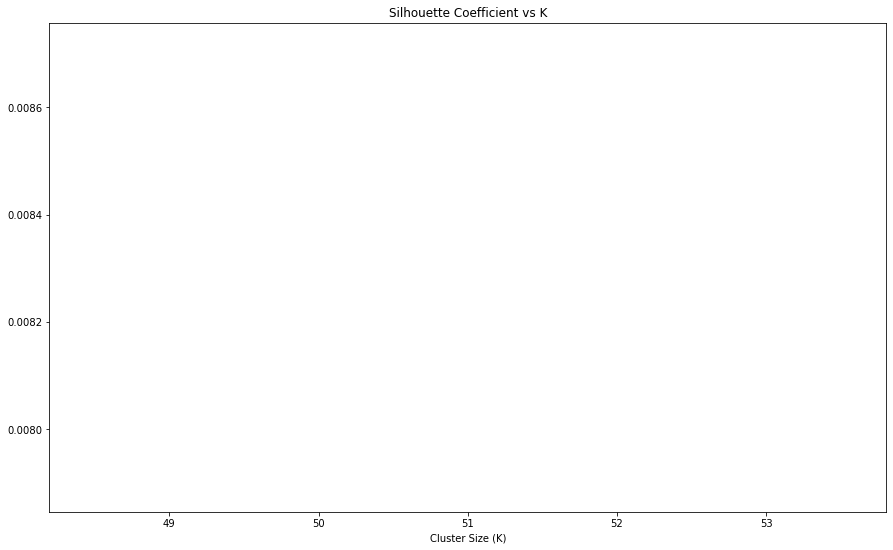

In [5]:
# K-Means clustering
# 
# Using the word-based TF-IDF, figure out what's the optimal number of
#  clusters to reduce our 20k-30k terms down into
#
# Note - we can't use lots of the scoring (eg completeness or homogeneity
#  or V-measure as we don't have a ground-truth)

KM = namedtuple('KM', 'k km scoff tfidf')

# Try a range of k-sizes
# A wide range is slow but lets us check what's best
# If we know what's almost right, a narrow range is fine!
krange = range(51, 52)
#krange = range(25, talks.shape[0]-25)

# Try each one with a few different inits, to avoid getting stuck in local-minima
kms = []
for k in krange:
    tfidf = tfidf_word

    print("Building k-means cluster of size %d" % k)
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, 
                n_init=15, verbose=False)
    km.fit(tfidf.matrix)
    # TODO Do we need to include labels / talk indexes?

    scoff = metrics.silhouette_score(tfidf.matrix, km.labels_, sample_size=1000)
    print(" - Silhouette Coefficient: %0.4f" % scoff)

    kms.append( KM(k,km,scoff,tfidf) )

# Save all the scores, so we can draw a graph
with open("outputs/cluster-scores.csv","w") as c:
   cw = csv.writer(c)
   cw.writerow(("k","Silhouette Coefficient"))
   for k in kms:
      cw.writerow((k.k, k.scoff))

# ----------------------------------------------------------------------------

# Visualise the Silhouette Coefficient vs K
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
ax.plot([k.k for k in kms], [k.scoff for k in kms])
ax.set(title="Silhouette Coefficient vs K", xlabel="Cluster Size (K)")
if len(kms) > 3:
   plt.show()

# ----------------------------------------------------------------------------

# Which one had the best Silhouette Coefficient?
kms.sort(key=lambda x: x.scoff, reverse=True)
best_km = kms[0]
print("")
print("Best K-Means found with a cluster-size (k) of %d" % best_km.k)
print("That had a Silhouette Coefficient: %0.4f" % best_km.scoff)

In [6]:
# What does our "Best Clustering" look like?
# What ended up where?

# Report some top features for a few clusters
def cluster_terms(km, top_clusters=4):
    # Work out the middle of each cluster
    order_centroids = km.km.cluster_centers_.argsort()[:, ::-1]

    # Print the top 10 features for the first few clusters
    terms = km.tfidf.tfidf.get_feature_names()
    for i in range(top_clusters):
        print(" - Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print('  %s ' % terms[ind], end='')
        print()
    print()
cluster_terms(best_km)

# If you want to visualise the top features of the clusters, rather
# than our simple printing them out, see
# https://buhrmann.github.io/tfidf-analysis.html

# ----------------------------------------------------------------------------

# Predict the best talks for a query based on the clusters

# Identify which cluster each talk belongs to
talk_clusters = best_km.km.predict(best_km.tfidf.matrix)
cluster_talks = defaultdict(list)
for talk_id, cluster_id in enumerate(talk_clusters):
    cluster_talks[cluster_id].append(talk_id)

#  - Work out which cluster our query best maps to
#  - Identify the talks in that cluster
#  - Find the centre of the cluster
#  - Do a regular similarity to work out the "closest" to the centre
def recommend_km(query, km, max_hits=10):
    query_tf = km.tfidf.tfidf.transform([query])
    cluster_id = int(km.km.predict(query_tf))
    print("Best cluster for '%s' is %d" % (query,cluster_id))
    
    c_centre_tfidf = km.km.cluster_centers_[cluster_id]
    c_talk_ids = cluster_talks[cluster_id]
    print(" - That cluster contains talks: %s" % c_talk_ids)

    # Compare all talks with this cluster centre
    similarities = linear_kernel(c_centre_tfidf.reshape(1, -1), km.tfidf.matrix)

    # Order, with a boost for ones in the cluster
    tscores = [[i,s] for i,s in enumerate(similarities[0])]
    for idx, score in tscores:
        if idx in c_talk_ids:
            tscores[idx][1] = score+0.01
    tscores = sorted(tscores, key=lambda x: x[1], reverse=True)

    # Get the indexes and scores of the x most similar talks
    tscores = tscores[0:max_hits]
    
    # Grab those talks
    indexes = [i[0] for i in tscores]
    return talks.iloc[indexes]

# ----------------------------------------------------------------------------

# Let's try it!
for q in queries:
    print("")
    print(q)
    print("")
    render( recommend_km(q, best_km, 10) )
    print("")

 - Cluster 0:  smack   osv   distribution   using stack   big data   big   stack   container   containers   partly 
 - Cluster 1:  ml   model   machine   machine learning   learning   deployment   production   models   training   end 
 - Cluster 2:  data streaming   streaming   stream   data   events   flink   apache flink   application   kafka   applications 
 - Cluster 3:  lucene   index   lucene search   apache lucene   search   billions   tweets   apache   documents   challenges faced 


apache tika

Best cluster for 'apache tika' is 5
 - That cluster contains talks: [42, 95, 140, 145, 157, 158, 160, 164, 183, 192, 203, 219, 221, 225, 258, 265, 266, 268, 281, 302, 324, 358, 362, 385, 419]


ngram

Best cluster for 'ngram' is 5
 - That cluster contains talks: [42, 95, 140, 145, 157, 158, 160, 164, 183, 192, 203, 219, 221, 225, 258, 265, 266, 268, 281, 302, 324, 358, 362, 385, 419]


nlp

Best cluster for 'nlp' is 6
 - That cluster contains talks: [9, 92, 106, 143, 155, 161, 177, 179

,year,title,level,track,speaker,url,abstract,learn
158,2019,"Python, Java, or Go: It's Your Choice with Apache Beam",Intermediate,Stream,Maximilian MichelsIsmaël Mejía,https://2019.berlinbuzzwords.de/19/session/python-java-or-go-its-your-choice-apache-beam.html,"With the rise of Tensorflow and libraries like Numpy, Python has become a popular choice for data processing. Applications built with Python are commonly single-node applications and need to be parallelized in order to scale for big amounts of data. Turns out, JVM-based languages are often the only choice to leverage the power of large-scale data processing tools like Apache Flink or Apache Spark.\nThis talk introduces Apache Beam, an open-source data processing framework for large-scale batch and stream processing which is designed with portability in mind. Apache Beam lets you use languages like Python, Go, Java, and Scala for data processing. Even better, the resulting programs can be run on the execution engine of your choice.\nWe will show how easy it is to run data processing jobs on Apache Beam and provide insight into different aspects of Apache Beam's portability architecture. In particular how Beam programs\nexecute on top of different execution engines like Apache Spark, Apache Flink, or Google Cloud Dataflow\nsupport multiple languages like Python, Go, and Java\n\nApache Beam's portability avoids being locked into a single execution engine or programming language. Moreover, portability enables completely new use cases, e.g. to create data processing jobs which mix multiple languages, to reuse Java IO connectors for loading/storing data from a Python job, or to use libraries (e.g. for machine learning) that do not exist in the main language of the data processing job.\nPlease join us to learn more about the future of data processing where users are free to choose their programming language and execution engine.\n \n","Python, Java, or Go: It's Your Choice with Apache Beam Stream With the rise of Tensorflow and libraries like Numpy, Python has become a popular choice for data processing. Applications built with Python are commonly single-node applications and need to be parallelized in order to scale for big amounts of data. Turns out, JVM-based languages are often the only choice to leverage the power of large-scale data processing tools like Apache Flink or Apache Spark.\nThis talk introduces Apache Beam, an open-source data processing framework for large-scale batch and stream processing which is designed with portability in mind. Apache Beam lets you use languages like Python, Go, Java, and Scala for data processing. Even better, the resulting programs can be run on the execution engine of your choice.\nWe will show how easy it is to run data processing jobs on Apache Beam and provide insight into different aspects of Apache Beam's portability architecture. In particular how Beam programs\nexecute on top of different execution engines like Apache Spark, Apache Flink, or Google Cloud Dataflow\nsupport multiple languages like Python, Go, and Java\n\nApache Beam's portability avoids being locked into a single execution engine or programming language. Moreover, portability enables completely new use cases, e.g. to create data processing jobs which mix multiple languages, to reuse Java IO connectors for loading/storing data from a Python job, or to use libraries (e.g. for machine learning) that do not exist in the main language of the data processing job.\nPlease join us to learn more about the future of data processing where users are free to choose their programming language and execution engine.\n \n"
95,2020,"First Steps with Apache Beam: Writing Portable Pipelines using Java, Python, Go",Intermediate,Stream,Austin Bennett,https://2020.berlinbuzzwords.de/session/first-steps-apache-beam-writing-portable-pipelines-using-java-python-go,"Apache Beam is an open source unified model for defining data processing pipelines (Batch and strEAM), which allows you to w

,year,title,level,track,speaker,url,abstract,learn
158,2019,"Python, Java, or Go: It's Your Choice with Apache Beam",Intermediate,Stream,Maximilian MichelsIsmaël Mejía,https://2019.berlinbuzzwords.de/19/session/python-java-or-go-its-your-choice-apache-beam.html,"With the rise of Tensorflow and libraries like Numpy, Python has become a popular choice for data processing. Applications built with Python are commonly single-node applications and need to be parallelized in order to scale for big amounts of data. Turns out, JVM-based languages are often the only choice to leverage the power of large-scale data processing tools like Apache Flink or Apache Spark.\nThis talk introduces Apache Beam, an open-source data processing framework for large-scale batch and stream processing which is designed with portability in mind. Apache Beam lets you use languages like Python, Go, Java, and Scala for data processing. Even better, the resulting programs can be run on the execution engine of your choice.\nWe will show how easy it is to run data processing jobs on Apache Beam and provide insight into different aspects of Apache Beam's portability architecture. In particular how Beam programs\nexecute on top of different execution engines like Apache Spark, Apache Flink, or Google Cloud Dataflow\nsupport multiple languages like Python, Go, and Java\n\nApache Beam's portability avoids being locked into a single execution engine or programming language. Moreover, portability enables completely new use cases, e.g. to create data processing jobs which mix multiple languages, to reuse Java IO connectors for loading/storing data from a Python job, or to use libraries (e.g. for machine learning) that do not exist in the main language of the data processing job.\nPlease join us to learn more about the future of data processing where users are free to choose their programming language and execution engine.\n \n","Python, Java, or Go: It's Your Choice with Apache Beam Stream With the rise of Tensorflow and libraries like Numpy, Python has become a popular choice for data processing. Applications built with Python are commonly single-node applications and need to be parallelized in order to scale for big amounts of data. Turns out, JVM-based languages are often the only choice to leverage the power of large-scale data processing tools like Apache Flink or Apache Spark.\nThis talk introduces Apache Beam, an open-source data processing framework for large-scale batch and stream processing which is designed with portability in mind. Apache Beam lets you use languages like Python, Go, Java, and Scala for data processing. Even better, the resulting programs can be run on the execution engine of your choice.\nWe will show how easy it is to run data processing jobs on Apache Beam and provide insight into different aspects of Apache Beam's portability architecture. In particular how Beam programs\nexecute on top of different execution engines like Apache Spark, Apache Flink, or Google Cloud Dataflow\nsupport multiple languages like Python, Go, and Java\n\nApache Beam's portability avoids being locked into a single execution engine or programming language. Moreover, portability enables completely new use cases, e.g. to create data processing jobs which mix multiple languages, to reuse Java IO connectors for loading/storing data from a Python job, or to use libraries (e.g. for machine learning) that do not exist in the main language of the data processing job.\nPlease join us to learn more about the future of data processing where users are free to choose their programming language and execution engine.\n \n"
95,2020,"First Steps with Apache Beam: Writing Portable Pipelines using Java, Python, Go",Intermediate,Stream,Austin Bennett,https://2020.berlinbuzzwords.de/session/first-steps-apache-beam-writing-portable-pipelines-using-java-python-go,"Apache Beam is an open source unified model for defining data processing pipelines (Batch and strEAM), which allows you to w

,year,title,level,track,speaker,url,abstract,learn
306,2017,BM25 is so Yesterday: Modern Techniques for Better Search Relevance,Intermediate,Search,Grant Ingersoll,https://2017.berlinbuzzwords.de/17/session/bm25-so-yesterday-modern-techniques-better-search-relevance.html,"Modern relevance in search engines has come a long way since the early days of information retrieval, when the likes of TF-IDF and BM25 scoring models first came on the scene. And while those core models are still good for a first pass retrieval, more and more search engines are employing machine learning, natural language processing and sophisticated re-ranking techniques to fine tune relevance. This talk will provide a review of current best practices in relevance tuning, including what to measure and how to measure it. We’ll then give details on how to use techniques like learning to rank and query intent classification to improve results, with examples in Apache Solr. We’ll finish with a sneak peak into using deep learning and word2vec in a search context.\n","BM25 is so Yesterday: Modern Techniques for Better Search Relevance Search Modern relevance in search engines has come a long way since the early days of information retrieval, when the likes of TF-IDF and BM25 scoring models first came on the scene. And while those core models are still good for a first pass retrieval, more and more search engines are employing machine learning, natural language processing and sophisticated re-ranking techniques to fine tune relevance. This talk will provide a review of current best practices in relevance tuning, including what to measure and how to measure it. We’ll then give details on how to use techniques like learning to rank and query intent classification to improve results, with examples in Apache Solr. We’ll finish with a sneak peak into using deep learning and word2vec in a search context.\n"
208,2018,"Machine Learning for Apache Solr, Elasticsearch & Vespa",Intermediate,Search,Mitali Jha,https://2018.berlinbuzzwords.de/18/session/machine-learning-apache-solr-elasticsearch-vespa.html,"Apache Solr, Elasticsearch and Vespa are three of the most popular general purpose search engines that are used in search, recommendations and analytics based applications. Machine learning is a critical aid to improving relevance beyond the native ranking algorithms (e.g. TF-IDF, BM25 etc.) by leveraging editorial judgements and user behaviour and factoring them into ranking of results. This is known as ""learning to rank"" (LTR) or ""machine learned ranking"" (MLR) etc.\nIn this talk, the speaker presents a comparison of machine learning frameworks across all of these search engines [1]. The comparison is followed by a quick demonstration on how to use all of these frameworks. This talk is aimed at those who are looking to decide upon which search engine to use in their applications based on the machine learned ranking capabilities available for it, and the ease of using such features.\n[1] 1. LTR based re-ranking module in Solr, https://lucene.apache.org/solr/guide/7_2/learning-to-rank.html 2. Elasticsearch's LTR plugin, https://github.com/o19s/elasticsearch-learning-to-rank 3. Vespa's MLR functionality, http://docs.vespa.ai/documentation/ranking.html\n \n","Machine Learning for Apache Solr, Elasticsearch & Vespa Search Apache Solr, Elasticsearch and Vespa are three of the most popular general purpose search engines that are used in search, recommendations and analytics based applications. Machine learning is a critical aid to improving relevance beyond the native ranking algorithms (e.g. TF-IDF, BM25 etc.) by leveraging editorial judgements and user behaviour and factoring them into ranking of results. This is known as ""learning to rank"" (LTR) or ""machine learned ranking"" (MLR) etc.\nIn this talk, the speaker presents a comparison of machine learning frameworks across all of these search engines [1]. The comparison is followed by a quick demonstration on how to use a

,year,title,level,track,speaker,url,abstract,learn
158,2019,"Python, Java, or Go: It's Your Choice with Apache Beam",Intermediate,Stream,Maximilian MichelsIsmaël Mejía,https://2019.berlinbuzzwords.de/19/session/python-java-or-go-its-your-choice-apache-beam.html,"With the rise of Tensorflow and libraries like Numpy, Python has become a popular choice for data processing. Applications built with Python are commonly single-node applications and need to be parallelized in order to scale for big amounts of data. Turns out, JVM-based languages are often the only choice to leverage the power of large-scale data processing tools like Apache Flink or Apache Spark.\nThis talk introduces Apache Beam, an open-source data processing framework for large-scale batch and stream processing which is designed with portability in mind. Apache Beam lets you use languages like Python, Go, Java, and Scala for data processing. Even better, the resulting programs can be run on the execution engine of your choice.\nWe will show how easy it is to run data processing jobs on Apache Beam and provide insight into different aspects of Apache Beam's portability architecture. In particular how Beam programs\nexecute on top of different execution engines like Apache Spark, Apache Flink, or Google Cloud Dataflow\nsupport multiple languages like Python, Go, and Java\n\nApache Beam's portability avoids being locked into a single execution engine or programming language. Moreover, portability enables completely new use cases, e.g. to create data processing jobs which mix multiple languages, to reuse Java IO connectors for loading/storing data from a Python job, or to use libraries (e.g. for machine learning) that do not exist in the main language of the data processing job.\nPlease join us to learn more about the future of data processing where users are free to choose their programming language and execution engine.\n \n","Python, Java, or Go: It's Your Choice with Apache Beam Stream With the rise of Tensorflow and libraries like Numpy, Python has become a popular choice for data processing. Applications built with Python are commonly single-node applications and need to be parallelized in order to scale for big amounts of data. Turns out, JVM-based languages are often the only choice to leverage the power of large-scale data processing tools like Apache Flink or Apache Spark.\nThis talk introduces Apache Beam, an open-source data processing framework for large-scale batch and stream processing which is designed with portability in mind. Apache Beam lets you use languages like Python, Go, Java, and Scala for data processing. Even better, the resulting programs can be run on the execution engine of your choice.\nWe will show how easy it is to run data processing jobs on Apache Beam and provide insight into different aspects of Apache Beam's portability architecture. In particular how Beam programs\nexecute on top of different execution engines like Apache Spark, Apache Flink, or Google Cloud Dataflow\nsupport multiple languages like Python, Go, and Java\n\nApache Beam's portability avoids being locked into a single execution engine or programming language. Moreover, portability enables completely new use cases, e.g. to create data processing jobs which mix multiple languages, to reuse Java IO connectors for loading/storing data from a Python job, or to use libraries (e.g. for machine learning) that do not exist in the main language of the data processing job.\nPlease join us to learn more about the future of data processing where users are free to choose their programming language and execution engine.\n \n"
95,2020,"First Steps with Apache Beam: Writing Portable Pipelines using Java, Python, Go",Intermediate,Stream,Austin Bennett,https://2020.berlinbuzzwords.de/session/first-steps-apache-beam-writing-portable-pipelines-using-java-python-go,"Apache Beam is an open source unified model for defining data processing pipelines (Batch and strEAM), which allows you to w

,year,title,level,track,speaker,url,abstract,learn
306,2017,BM25 is so Yesterday: Modern Techniques for Better Search Relevance,Intermediate,Search,Grant Ingersoll,https://2017.berlinbuzzwords.de/17/session/bm25-so-yesterday-modern-techniques-better-search-relevance.html,"Modern relevance in search engines has come a long way since the early days of information retrieval, when the likes of TF-IDF and BM25 scoring models first came on the scene. And while those core models are still good for a first pass retrieval, more and more search engines are employing machine learning, natural language processing and sophisticated re-ranking techniques to fine tune relevance. This talk will provide a review of current best practices in relevance tuning, including what to measure and how to measure it. We’ll then give details on how to use techniques like learning to rank and query intent classification to improve results, with examples in Apache Solr. We’ll finish with a sneak peak into using deep learning and word2vec in a search context.\n","BM25 is so Yesterday: Modern Techniques for Better Search Relevance Search Modern relevance in search engines has come a long way since the early days of information retrieval, when the likes of TF-IDF and BM25 scoring models first came on the scene. And while those core models are still good for a first pass retrieval, more and more search engines are employing machine learning, natural language processing and sophisticated re-ranking techniques to fine tune relevance. This talk will provide a review of current best practices in relevance tuning, including what to measure and how to measure it. We’ll then give details on how to use techniques like learning to rank and query intent classification to improve results, with examples in Apache Solr. We’ll finish with a sneak peak into using deep learning and word2vec in a search context.\n"
208,2018,"Machine Learning for Apache Solr, Elasticsearch & Vespa",Intermediate,Search,Mitali Jha,https://2018.berlinbuzzwords.de/18/session/machine-learning-apache-solr-elasticsearch-vespa.html,"Apache Solr, Elasticsearch and Vespa are three of the most popular general purpose search engines that are used in search, recommendations and analytics based applications. Machine learning is a critical aid to improving relevance beyond the native ranking algorithms (e.g. TF-IDF, BM25 etc.) by leveraging editorial judgements and user behaviour and factoring them into ranking of results. This is known as ""learning to rank"" (LTR) or ""machine learned ranking"" (MLR) etc.\nIn this talk, the speaker presents a comparison of machine learning frameworks across all of these search engines [1]. The comparison is followed by a quick demonstration on how to use all of these frameworks. This talk is aimed at those who are looking to decide upon which search engine to use in their applications based on the machine learned ranking capabilities available for it, and the ease of using such features.\n[1] 1. LTR based re-ranking module in Solr, https://lucene.apache.org/solr/guide/7_2/learning-to-rank.html 2. Elasticsearch's LTR plugin, https://github.com/o19s/elasticsearch-learning-to-rank 3. Vespa's MLR functionality, http://docs.vespa.ai/documentation/ranking.html\n \n","Machine Learning for Apache Solr, Elasticsearch & Vespa Search Apache Solr, Elasticsearch and Vespa are three of the most popular general purpose search engines that are used in search, recommendations and analytics based applications. Machine learning is a critical aid to improving relevance beyond the native ranking algorithms (e.g. TF-IDF, BM25 etc.) by leveraging editorial judgements and user behaviour and factoring them into ranking of results. This is known as ""learning to rank"" (LTR) or ""machine learned ranking"" (MLR) etc.\nIn this talk, the speaker presents a comparison of machine learning frameworks across all of these search engines [1]. The comparison is followed by a quick demonstration on how to use a

In [ ]:
# Try to visualise the ~50 clusters in 2 dimensions

def make_tsne():
   tsne_init = 'pca'  # could also be 'random'
   tsne_perplexity = 20.0
   tsne_early_exaggeration = 4.0
   tsne_learning_rate = 1000
   random_state = 1
   return TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
               early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

def visualise_km_tsne(centroids):
   model = make_tsne()
   transformed_centroids = model.fit_transform(centroids)
   fig = plt.figure(figsize=(15,9))
   plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
   plt.show()

visualise_km_tsne(best_km.km.cluster_centers_)

# ----------------------------------------------------------------------------

# How does that clustering compare to the original TF-IDF data?
def visualise_tfidf_tsne(tfidf_matrix):
   # Build a TSVD reducer, to get us down to ~50 dimensions
   reducer = TruncatedSVD(n_components=50, random_state=0)
   print(tfidf_matrix.shape)
   tfidf_reduced = reducer.fit_transform(tfidf_matrix)
   print(tfidf_reduced.shape)

   # Use t-SNE to get down to 2 dimensions
   tfidf_emb = make_tsne().fit_transform(tfidf_reduced)

   # Plot it
   fig = plt.figure(figsize=(15, 10))
   ax = plt.axes(frameon=False)
   ax.set(title="t-SNE visualisation of raw TF-IDF")
   plt.setp(ax, xticks=(), yticks=())
   plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                       wspace=0.0, hspace=0.0)
   plt.scatter(tfidf_emb[:, 0], tfidf_emb[:, 1], c=talk_clusters, marker="x")
   plt.show()

visualise_tfidf_tsne(tfidf_word.matrix)

In [ ]:
# TODO Try using OPICS (Ordering Points To Identify the Clustering Structure)
#  to try to identify talk clusters
# Will need manual review to help identify the hyperparameters, especially
#  around the cluster difference
# Once clusters, then pull out the top words for each cluster, identify
#  likely talks from clusters etc
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html

# ----------------------------------------------------------------------------

# While we could go further with SciKitLearn, it's time to 
#  swap over to Apache MXNet!